<a href="https://colab.research.google.com/github/mtayeb89/Active-Directory-Management-Tool/blob/main/Text_to_Icon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# ================================================================
# TEXT-TO-ICON GENERATOR (16×16) - HANDS-ON WORKSHOP
# ================================================================
# This notebook creates a simple AI model that generates 16×16 pixel
# icons from text descriptions like "blue heart" or "red star"
# ================================================================

# ================================================================
# STEP 1: INSTALL AND IMPORT LIBRARIES
# ================================================================
# Install required packages (run this cell first in Colab)

!pip install torch torchvision numpy matplotlib Pillow tqdm -q

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import random
from tqdm import tqdm
import os

# Set device (GPU if available, otherwise CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

Using device: cuda


In [4]:
# ================================================================
# STEP 2: CREATE SYNTHETIC DATASET (50,000 samples)
# ================================================================
# We'll generate simple geometric shapes with different colors
# This simulates a real dataset of icons

class IconDatasetGenerator:
    """Generates synthetic icon data with text descriptions"""

    def __init__(self, num_samples=50000, img_size=16):
        self.num_samples = num_samples
        self.img_size = img_size

        # Define possible colors (name: RGB values)
        self.colors = {
            'red': (255, 0, 0),
            'blue': (0, 0, 255),
            'green': (0, 255, 0),
            'yellow': (255, 255, 0),
            'purple': (128, 0, 128),
            'orange': (255, 165, 0),
            'pink': (255, 192, 203),
            'cyan': (0, 255, 255)
        }

        # Define possible shapes
        self.shapes = ['circle', 'square', 'triangle', 'heart', 'star']

    def draw_circle(self, draw, color):
        """Draw a circle on the image"""
        draw.ellipse([4, 4, 12, 12], fill=color)

    def draw_square(self, draw, color):
        """Draw a square on the image"""
        draw.rectangle([4, 4, 12, 12], fill=color)

    def draw_triangle(self, draw, color):
        """Draw a triangle on the image"""
        draw.polygon([8, 4, 12, 12, 4, 12], fill=color)

    def draw_heart(self, draw, color):
        """Draw a simple heart shape"""
        draw.polygon([8, 12, 4, 8, 5, 6, 8, 5, 11, 6, 12, 8], fill=color)

    def draw_star(self, draw, color):
        """Draw a simple star shape"""
        draw.polygon([8, 4, 9, 7, 12, 7, 10, 9, 11, 12, 8, 10, 5, 12, 6, 9, 4, 7, 7, 7], fill=color)

    def generate_icon(self, shape, color_name):
        """Generate a single icon image"""
        # Create blank white image
        img = Image.new('RGB', (self.img_size, self.img_size), color='white')
        draw = ImageDraw.Draw(img)

        # Get color RGB values
        color = self.colors[color_name]

        # Draw the shape
        if shape == 'circle':
            self.draw_circle(draw, color)
        elif shape == 'square':
            self.draw_square(draw, color)
        elif shape == 'triangle':
            self.draw_triangle(draw, color)
        elif shape == 'heart':
            self.draw_heart(draw, color)
        elif shape == 'star':
            self.draw_star(draw, color)

        return img

    def generate_dataset(self):
        """Generate the complete dataset"""
        texts = []
        images = []

        print(f"Generating {self.num_samples} icon samples...")

        for i in tqdm(range(self.num_samples)):
            # Randomly select color and shape
            color_name = random.choice(list(self.colors.keys()))
            shape = random.choice(self.shapes)

            # Create text description
            text = f"{color_name} {shape}"

            # Generate icon
            img = self.generate_icon(shape, color_name)

            # Convert to numpy array and normalize to [0, 1]
            img_array = np.array(img).astype(np.float32) / 255.0

            texts.append(text)
            images.append(img_array)

        return texts, np.array(images)

# Generate the dataset
print("\n" + "="*60)
print("GENERATING DATASET")
print("="*60)
generator = IconDatasetGenerator(num_samples=50000)
texts, images = generator.generate_dataset()

print(f"\nDataset created:")
print(f"  - Number of samples: {len(texts)}")
print(f"  - Image shape: {images.shape}")
print(f"  - Sample texts: {texts[:5]}")


GENERATING DATASET
Generating 50000 icon samples...


100%|██████████| 50000/50000 [00:02<00:00, 21267.86it/s]



Dataset created:
  - Number of samples: 50000
  - Image shape: (50000, 16, 16, 3)
  - Sample texts: ['blue circle', 'purple square', 'yellow square', 'blue star', 'blue star']


In [5]:
# ================================================================
# STEP 3: CREATE VOCABULARY FOR TEXT ENCODING
# ================================================================
# Build a vocabulary of all unique words in our dataset

class Vocabulary:
    """Create vocabulary for encoding text to numbers"""

    def __init__(self):
        self.word2idx = {'<PAD>': 0, '<UNK>': 1}  # Special tokens
        self.idx2word = {0: '<PAD>', 1: '<UNK>'}
        self.idx = 2

    def build_vocab(self, texts):
        """Build vocabulary from list of texts"""
        for text in texts:
            for word in text.split():
                if word not in self.word2idx:
                    self.word2idx[word] = self.idx
                    self.idx2word[self.idx] = word
                    self.idx += 1

    def encode(self, text, max_len=5):
        """Convert text to list of indices"""
        words = text.split()
        indices = [self.word2idx.get(word, 1) for word in words]

        # Pad or truncate to max_len
        if len(indices) < max_len:
            indices += [0] * (max_len - len(indices))
        else:
            indices = indices[:max_len]

        return indices

    def __len__(self):
        return len(self.word2idx)

# Build vocabulary
print("\n" + "="*60)
print("BUILDING VOCABULARY")
print("="*60)
vocab = Vocabulary()
vocab.build_vocab(texts)
print(f"Vocabulary size: {len(vocab)}")
print(f"Word to index mapping: {vocab.word2idx}")



BUILDING VOCABULARY
Vocabulary size: 15
Word to index mapping: {'<PAD>': 0, '<UNK>': 1, 'blue': 2, 'circle': 3, 'purple': 4, 'square': 5, 'yellow': 6, 'star': 7, 'pink': 8, 'red': 9, 'cyan': 10, 'green': 11, 'heart': 12, 'orange': 13, 'triangle': 14}


In [6]:
# ================================================================
# STEP 4: CREATE PYTORCH DATASET CLASS
# ================================================================
# Wrap our data in a PyTorch Dataset for efficient loading

class IconDataset(Dataset):
    """PyTorch Dataset for icon generation"""

    def __init__(self, texts, images, vocab):
        self.texts = texts
        self.images = images
        self.vocab = vocab

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        # Get text and encode it
        text = self.texts[idx]
        text_encoded = self.vocab.encode(text)

        # Get image and transpose to (channels, height, width)
        image = self.images[idx]
        image = image.transpose(2, 0, 1)  # (H, W, C) -> (C, H, W)

        return torch.tensor(text_encoded, dtype=torch.long), torch.tensor(image, dtype=torch.float32)

# Split dataset into train and validation sets (90% train, 10% val)
split_idx = int(0.9 * len(texts))
train_texts, val_texts = texts[:split_idx], texts[split_idx:]
train_images, val_images = images[:split_idx], images[split_idx:]

# Create datasets
train_dataset = IconDataset(train_texts, train_images, vocab)
val_dataset = IconDataset(val_texts, val_images, vocab)

# Create data loaders (batch size = 64)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

print(f"\nDataset split:")
print(f"  - Training samples: {len(train_dataset)}")
print(f"  - Validation samples: {len(val_dataset)}")
print(f"  - Batch size: 64")



Dataset split:
  - Training samples: 45000
  - Validation samples: 5000
  - Batch size: 64


In [7]:
# ================================================================
# STEP 5: BUILD THE MODEL ARCHITECTURE
# ================================================================
# Create the text-to-icon generator model

class TextEncoder(nn.Module):
    """Encodes text into a feature vector using Embedding + LSTM"""

    def __init__(self, vocab_size, embed_dim=32, hidden_dim=64):
        super(TextEncoder, self).__init__()

        # Embedding layer: converts word indices to dense vectors
        self.embedding = nn.Embedding(vocab_size, embed_dim)

        # LSTM: processes sequence of word embeddings
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)

    def forward(self, text):
        # text shape: (batch_size, seq_len)
        embedded = self.embedding(text)  # (batch_size, seq_len, embed_dim)
        _, (hidden, _) = self.lstm(embedded)  # hidden: (1, batch_size, hidden_dim)
        return hidden.squeeze(0)  # (batch_size, hidden_dim)

class ImageDecoder(nn.Module):
    """Decodes feature vector into 16×16 RGB image"""

    def __init__(self, input_dim=64, img_size=16):
        super(ImageDecoder, self).__init__()
        self.img_size = img_size

        # Dense layer: expands feature vector to large dimension
        self.fc = nn.Linear(input_dim, 256)

        # Reshape to prepare for convolutions
        self.reshape_dim = 64  # Will reshape to (64, 2, 2)

        # Transposed convolutions: gradually upsample to 16×16
        self.decoder = nn.Sequential(
            # 2×2 -> 4×4
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),

            # 4×4 -> 8×8
            nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),

            # 8×8 -> 16×16
            nn.ConvTranspose2d(16, 3, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()  # Output in range [0, 1]
        )

    def forward(self, x):
        # x shape: (batch_size, 64)
        x = self.fc(x)  # (batch_size, 256)
        x = x.view(-1, 64, 2, 2)  # Reshape to (batch_size, 64, 2, 2)
        x = self.decoder(x)  # (batch_size, 3, 16, 16)
        return x

class TextToIconModel(nn.Module):
    """Complete text-to-icon generation model"""

    def __init__(self, vocab_size):
        super(TextToIconModel, self).__init__()
        self.encoder = TextEncoder(vocab_size)
        self.decoder = ImageDecoder()

    def forward(self, text):
        features = self.encoder(text)  # Encode text to features
        image = self.decoder(features)  # Decode features to image
        return image

# Create model and move to device (GPU/CPU)
print("\n" + "="*60)
print("BUILDING MODEL")
print("="*60)
model = TextToIconModel(vocab_size=len(vocab)).to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"Model created with {total_params:,} parameters")
print(f"\nModel architecture:")
print(model)


BUILDING MODEL
Model created with 83,987 parameters

Model architecture:
TextToIconModel(
  (encoder): TextEncoder(
    (embedding): Embedding(15, 32)
    (lstm): LSTM(32, 64, batch_first=True)
  )
  (decoder): ImageDecoder(
    (fc): Linear(in_features=64, out_features=256, bias=True)
    (decoder): Sequential(
      (0): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): ReLU()
      (2): ConvTranspose2d(32, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (3): ReLU()
      (4): ConvTranspose2d(16, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (5): Sigmoid()
    )
  )
)


In [8]:
# ================================================================
# STEP 6: DEFINE LOSS FUNCTION AND OPTIMIZER
# ================================================================
# Set up training components

# Loss function: Mean Squared Error (measures pixel-wise difference)
criterion = nn.MSELoss()

# Optimizer: Adam (adaptive learning rate optimizer)
optimizer = optim.Adam(model.parameters(), lr=0.001)

print("\n" + "="*60)
print("TRAINING SETUP")
print("="*60)
print(f"Loss function: MSE (Mean Squared Error)")
print(f"Optimizer: Adam (learning rate = 0.001)")



TRAINING SETUP
Loss function: MSE (Mean Squared Error)
Optimizer: Adam (learning rate = 0.001)


In [9]:
# ================================================================
# STEP 7: TRAINING LOOP
# ================================================================
# Train the model for multiple epochs

def train_epoch(model, train_loader, criterion, optimizer, device):
    """Train for one epoch"""
    model.train()
    total_loss = 0

    for text, target_img in train_loader:
        text = text.to(device)
        target_img = target_img.to(device)

        # Forward pass
        pred_img = model(text)
        loss = criterion(pred_img, target_img)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(train_loader)

def validate(model, val_loader, criterion, device):
    """Validate the model"""
    model.eval()
    total_loss = 0

    with torch.no_grad():
        for text, target_img in val_loader:
            text = text.to(device)
            target_img = target_img.to(device)

            pred_img = model(text)
            loss = criterion(pred_img, target_img)
            total_loss += loss.item()

    return total_loss / len(val_loader)

# Training loop
print("\n" + "="*60)
print("TRAINING MODEL")
print("="*60)

num_epochs = 20
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    # Train
    train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
    train_losses.append(train_loss)

    # Validate
    val_loss = validate(model, val_loader, criterion, device)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.6f} - Val Loss: {val_loss:.6f}")

print("\nTraining completed!")


TRAINING MODEL
Epoch 1/20 - Train Loss: 0.056651 - Val Loss: 0.014635
Epoch 2/20 - Train Loss: 0.006921 - Val Loss: 0.002271
Epoch 3/20 - Train Loss: 0.001990 - Val Loss: 0.001919
Epoch 4/20 - Train Loss: 0.001692 - Val Loss: 0.001655
Epoch 5/20 - Train Loss: 0.001407 - Val Loss: 0.001409
Epoch 6/20 - Train Loss: 0.001195 - Val Loss: 0.001125
Epoch 7/20 - Train Loss: 0.000924 - Val Loss: 0.000791
Epoch 8/20 - Train Loss: 0.000687 - Val Loss: 0.000662
Epoch 9/20 - Train Loss: 0.000649 - Val Loss: 0.000651
Epoch 10/20 - Train Loss: 0.000647 - Val Loss: 0.000640
Epoch 11/20 - Train Loss: 0.000634 - Val Loss: 0.000757
Epoch 12/20 - Train Loss: 0.000622 - Val Loss: 0.000830
Epoch 13/20 - Train Loss: 0.000655 - Val Loss: 0.000715
Epoch 14/20 - Train Loss: 0.000618 - Val Loss: 0.000675
Epoch 15/20 - Train Loss: 0.000605 - Val Loss: 0.000587
Epoch 16/20 - Train Loss: 0.000159 - Val Loss: 0.000046
Epoch 17/20 - Train Loss: 0.000049 - Val Loss: 0.000049
Epoch 18/20 - Train Loss: 0.000056 - Val 

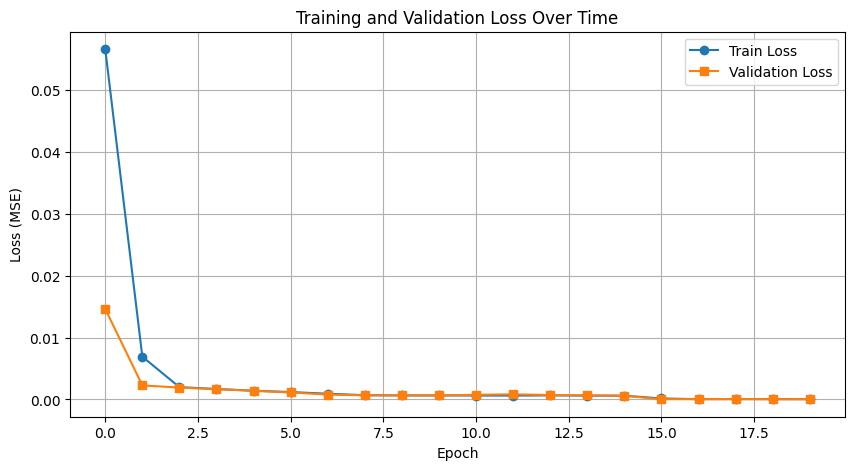

In [10]:
# ================================================================
# STEP 8: PLOT TRAINING CURVES
# ================================================================
# Visualize training progress

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss', marker='o')
plt.plot(val_losses, label='Validation Loss', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Training and Validation Loss Over Time')
plt.legend()
plt.grid(True)
plt.show()


GENERATING SAMPLE ICONS


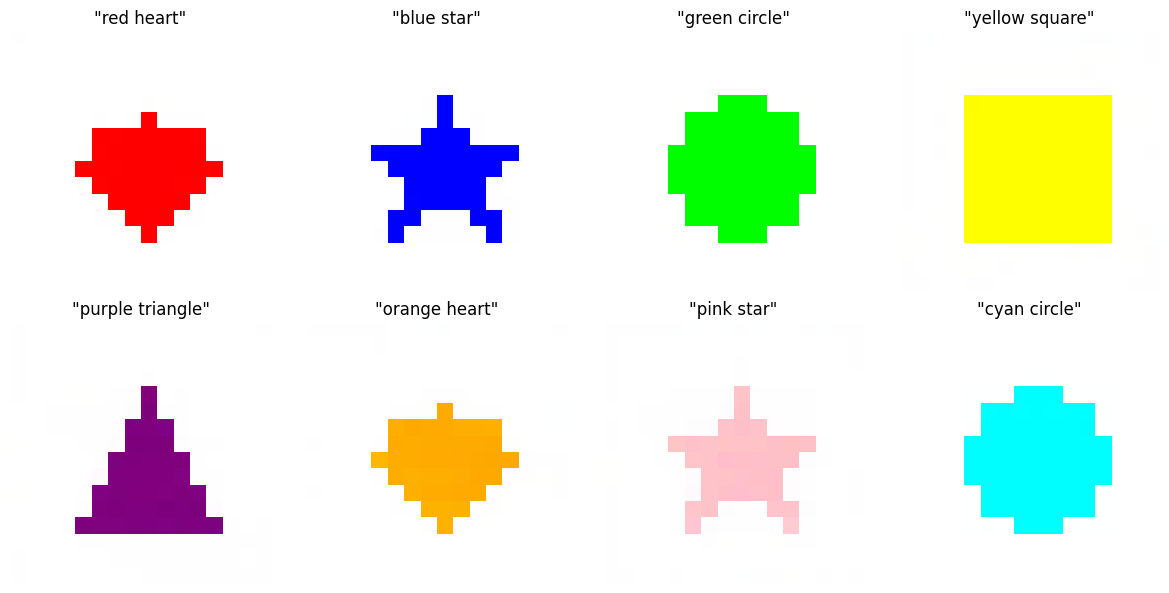

In [11]:
# ================================================================
# STEP 9: TEST THE MODEL WITH SAMPLES
# ================================================================
# Generate icons from text prompts

def generate_icon(model, text, vocab, device):
    """Generate icon from text description"""
    model.eval()

    # Encode text
    text_encoded = vocab.encode(text)
    text_tensor = torch.tensor([text_encoded], dtype=torch.long).to(device)

    # Generate image
    with torch.no_grad():
        img = model(text_tensor)

    # Convert to numpy and transpose
    img = img.cpu().numpy()[0].transpose(1, 2, 0)
    img = np.clip(img, 0, 1)  # Ensure values are in [0, 1]

    return img

# Test with sample prompts
print("\n" + "="*60)
print("GENERATING SAMPLE ICONS")
print("="*60)

test_prompts = [
    "red heart",
    "blue star",
    "green circle",
    "yellow square",
    "purple triangle",
    "orange heart",
    "pink star",
    "cyan circle"
]

fig, axes = plt.subplots(2, 4, figsize=(12, 6))
axes = axes.flatten()

for idx, prompt in enumerate(test_prompts):
    img = generate_icon(model, prompt, vocab, device)
    axes[idx].imshow(img)
    axes[idx].set_title(f'"{prompt}"')
    axes[idx].axis('off')

plt.tight_layout()
plt.show()



COMPARISON: GENERATED vs TARGET


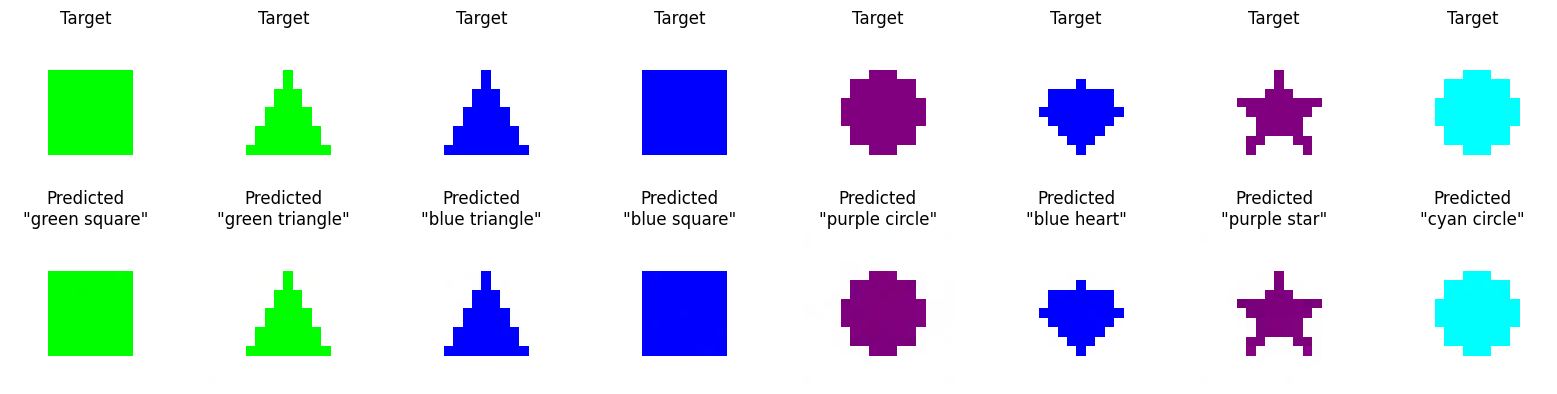

In [12]:
# ================================================================
# STEP 10: COMPARE WITH GROUND TRUTH
# ================================================================
# Compare generated icons with actual target icons

print("\n" + "="*60)
print("COMPARISON: GENERATED vs TARGET")
print("="*60)

# Get a batch from validation set
val_iter = iter(val_loader)
text_batch, target_batch = next(val_iter)

# Generate predictions
model.eval()
with torch.no_grad():
    pred_batch = model(text_batch.to(device))

# Visualize comparisons
num_compare = 8
fig, axes = plt.subplots(2, num_compare, figsize=(16, 4))

for i in range(num_compare):
    # Target image
    target_img = target_batch[i].cpu().numpy().transpose(1, 2, 0)
    axes[0, i].imshow(target_img)
    axes[0, i].set_title('Target')
    axes[0, i].axis('off')

    # Predicted image
    pred_img = pred_batch[i].cpu().numpy().transpose(1, 2, 0)
    pred_img = np.clip(pred_img, 0, 1)
    axes[1, i].imshow(pred_img)

    # Decode text to show prompt
    text_indices = text_batch[i].tolist()
    words = [vocab.idx2word.get(idx, '') for idx in text_indices if idx != 0]
    prompt = ' '.join(words)
    axes[1, i].set_title(f'Predicted\n"{prompt}"')
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

In [13]:
# ================================================================
# STEP 11: SAVE THE MODEL (OPTIONAL)
# ================================================================
# Save trained model for future use

print("\n" + "="*60)
print("SAVING MODEL")
print("="*60)

# Save model weights
torch.save({
    'model_state_dict': model.state_dict(),
    'vocab': vocab,
    'config': {
        'vocab_size': len(vocab),
        'img_size': 16
    }
}, 'text_to_icon_model.pth')

print("Model saved as 'text_to_icon_model.pth'")


SAVING MODEL
Model saved as 'text_to_icon_model.pth'



INTERACTIVE TESTING
Available colors: red, blue, green, yellow, purple, orange, pink, cyan
Available shapes: circle, square, triangle, heart, star

Try these examples or create your own:


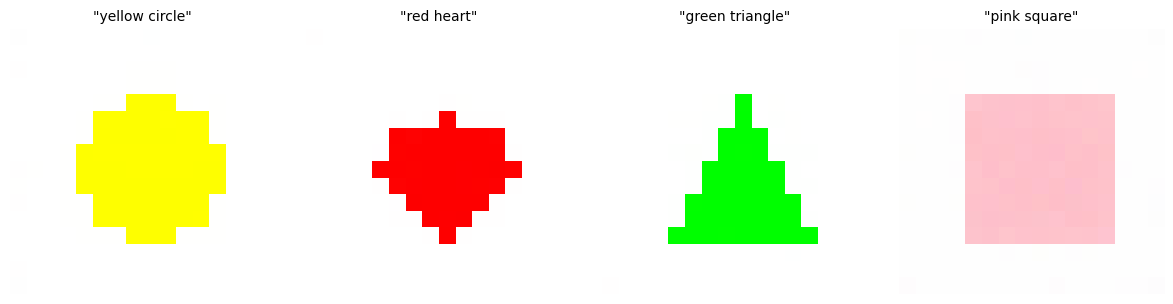


WORKSHOP COMPLETED!

Key takeaways:
1. Text Encoder: Converts words to feature vectors using Embedding + LSTM
2. Image Decoder: Converts features to images using Conv2DTranspose
3. Training: Used MSE loss to minimize pixel-wise differences
4. Dataset: 50,000 synthetic icons with 8 colors × 5 shapes

Next steps:
- Try modifying the architecture (add more layers, change dimensions)
- Experiment with different learning rates
- Add more colors or shapes to the dataset
- Try training on real icon datasets


In [14]:
# ================================================================
# STEP 12: INTERACTIVE TESTING
# ================================================================
# Test with your own prompts!

print("\n" + "="*60)
print("INTERACTIVE TESTING")
print("="*60)
print("Available colors: red, blue, green, yellow, purple, orange, pink, cyan")
print("Available shapes: circle, square, triangle, heart, star")
print("\nTry these examples or create your own:")

# Example prompts
custom_prompts = [
    "yellow circle",
    "red heart",
    "green triangle",
    "pink square"
]

fig, axes = plt.subplots(1, 4, figsize=(12, 3))

for idx, prompt in enumerate(custom_prompts):
    img = generate_icon(model, prompt, vocab, device)
    axes[idx].imshow(img)
    axes[idx].set_title(f'"{prompt}"', fontsize=10)
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("WORKSHOP COMPLETED!")
print("="*60)
print("\nKey takeaways:")
print("1. Text Encoder: Converts words to feature vectors using Embedding + LSTM")
print("2. Image Decoder: Converts features to images using Conv2DTranspose")
print("3. Training: Used MSE loss to minimize pixel-wise differences")
print("4. Dataset: 50,000 synthetic icons with 8 colors × 5 shapes")
print("\nNext steps:")
print("- Try modifying the architecture (add more layers, change dimensions)")
print("- Experiment with different learning rates")
print("- Add more colors or shapes to the dataset")
print("- Try training on real icon datasets")
print("="*60)